# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'Federico Chiarello'
ID_number = int('2058163')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# First Homework - Multi-Armed Bandits and Dynamic Programming

The present homework contains 2 exercises, one related to Multi-Armed Bandit problem and the other to Dynamic Programming.

- Delivery date: 26/10/2022

- Submission deadline: 09/11/2022 (23:59)

# Nonstationary Multi-Armed Bandits

The first part of the homework deals with the Multi Armed Bandit Problem.
In particular, the 10-armed testbed environment is exploited in order to understand what happens when dynamics are introduced in the arm rewards.
In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $\mu(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ \mu_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$\mu_t(a) = \mu_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Then $$ q_t(a) =  \mathcal{N}(\mu_t(a), 1) \qquad \forall a \in \mathcal{A}$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'rewards' which is a numpy nd-array containing the average (over different runs) rewards of the two algorithms! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

In [2]:
# Install packages in ipython
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## Credits and imports

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

For your convenience, the code discussed in the first "tutorial lesson" is reported below. Feel free to modify the code as you wish in order to achieve the required result.


In [4]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    
    
    # YOUR CODE HERE
    
    
    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)

        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
            
            
        # Mean Values Independent Random Walks
        
        # Generate the white noise
        white_noise = 0.1 * np.random.randn(self.k)
        # Add the white noise to q_true (arms mean vector)
        self.q_true = self.q_true + white_noise 
        # select the best action
        self.best_action = np.argmax(self.q_true)
        
        return reward
    
    
    
    def reset(self):
        
        # mean values of all the arms start out equal to 0
        self.q_true = np.zeros(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial 

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        # select the best action
        self.best_action = np.argmax(self.q_true)

        self.time = 0



def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    cumulative_mean_rewards = np.cumsum(mean_rewards, axis = 1)
    return mean_best_action_counts, mean_rewards, cumulative_mean_rewards

# Recall you have to modify the environment above!

# Code for the figures
# YOUR CODE HERE


In [5]:
runs=500; time=5000 

bandits = []
bandits.append(Bandit(epsilon=0.1, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, step_size=0.1))
best_action_counts, rewards, cumulative_average_rewards = simulate(runs, time, bandits)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.59it/s]


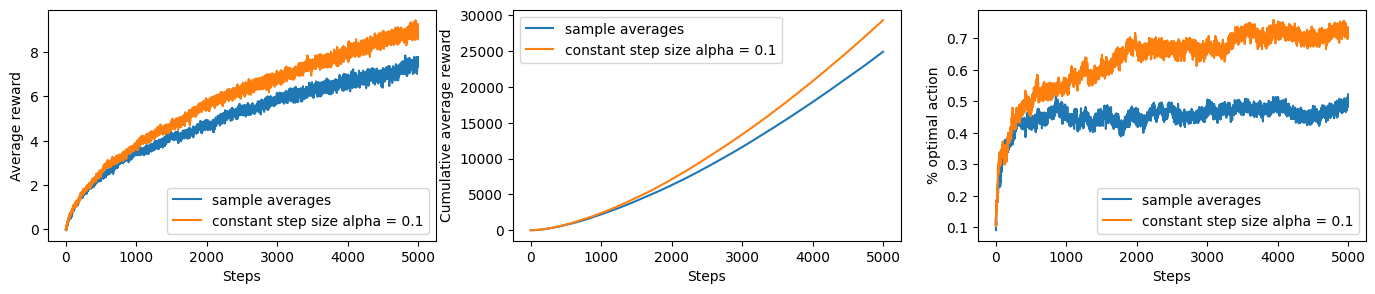

In [15]:
plt.figure(figsize=(17, 3))

plt.subplot(1, 3, 1)
plt.plot(rewards[0], label='sample averages')
plt.plot(rewards[1], label='constant step size alpha = 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cumulative_average_rewards[0], label='sample averages')
plt.plot(cumulative_average_rewards[1], label='constant step size alpha = 0.1')
plt.xlabel('Steps')
plt.ylabel('Cumulative average reward')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(best_action_counts[0], label='sample averages')
plt.plot(best_action_counts[1], label='constant step size alpha = 0.1')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()

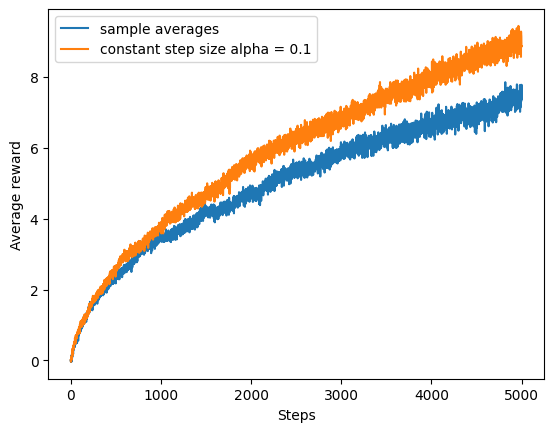

In [7]:
plt.plot(rewards[0], label='sample averages')
plt.plot(rewards[1], label='constant step size alpha = 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

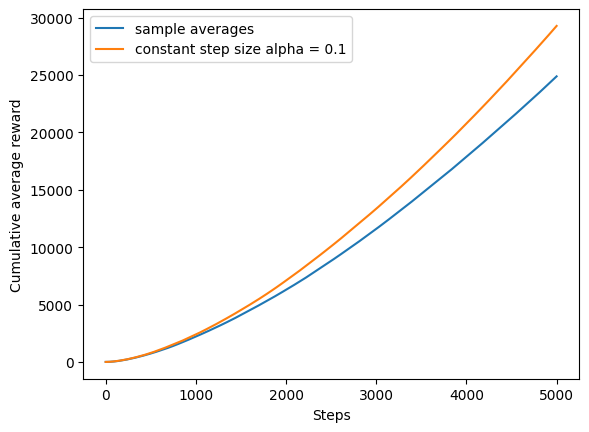

In [9]:
plt.plot(cumulative_average_rewards[0], label='sample averages')
plt.plot(cumulative_average_rewards[1], label='constant step size alpha = 0.1')
plt.xlabel('Steps')
plt.ylabel('Cumulative average reward')
plt.legend()

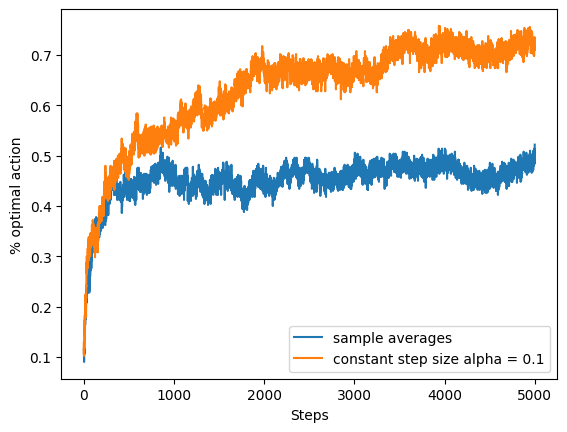

In [8]:
plt.plot(best_action_counts[0], label='sample averages')
plt.plot(best_action_counts[1], label='constant step size alpha = 0.1')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

In [10]:
# HERE ENDS THE FIRST EXERCISE
assert rewards.shape == (2, 5000)

Comment your results in the cell below. Which algorithm performed best? With respsect to which metric? Why? [~15 lines]

YOUR ANSWER HERE

# Jack against the nationwide company

The second part of the homework consists of a modification of the Jack's Car Rental problem discussed during the second "Tutorial Lecture".
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to **shuttle one car to the second location for free**, while each additional car costs the usual $2\$$. Moreover, the nationwide car rental company has changed its policy on parking spaces: for each location now Jack can only park up to 10 vehicles free of charge. **If more than 10 cars are kept overnight at a location, then an additional cost of $4\$$ must be incurred** to use a second parking lot (independent of how many cars are kept there). The car rental company charges Jack with the additional parking lots price first thing in the morning, **before any possible moving of cars**.
In order to fulfill the exercise requirements, you need to **modify and solve** the new instance of the Jack's car rental problem with a **Value Iteration** algorithm.
Generate a subplot with six cells as the one seen in the "Tutorial Lecture" with the figures of 5 policies at different iterations: #0, #7, #14, #21, and the last (optimal!) one. In the sixth box plot the optimal value-function.
Use $\texttt{constant}$_$\texttt{returned}$_$\texttt{cars}$ = **True**.

**Optional assignment:** 
consider an additional cost, when the customers return more cars than a facility is able to accomodate (MAX_CARS) Jack has to pay a tow truck to carry them to a third location of the nationwide company. Suppose that the truck can carry all the extra cars, and it costs 4 \$ for a single location. Be careful of where you encode this in the script. 

If you decide to implement this extra point, make sure to set $\text{OPTIONAL}$_$\text{POINT}$ = **True**, otherwise leave it to **False**.


##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'policy' which is a numpy nd-array containing the optimal action for each pair of states, as in the notebook of the second "Tutorial Lecture"! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

C:\Users\feder\AppData\Local\Temp\ipykernel_12572\3982151229.py:126: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros(value.shape, dtype=np.int)


max value change 175.16107399736472
max value change 121.26804352657942
max value change 83.24561955690575
max value change 65.00525737205288
max value change 50.2274761188379
max value change 37.96075571401616
max value change 29.343222189210536
max value change 25.61281889764615
max value change 22.232304837725707
max value change 19.22351441366726
max value change 16.575732052271803
max value change 14.263045320520973
max value change 12.253473577032082
max value change 10.513743211422991
max value change 9.01173201723276
max value change 7.717649732149198
max value change 6.604524053917032
max value change 5.648305254909189
max value change 4.827767133212831
max value change 4.124306709276709
max value change 3.521701332778605
max value change 3.005856017459166
max value change 2.564558607391291
max value change 2.187251554705938
max value change 1.864824070853217
max value change 1.5894256261307191
max value change 1.3543002735504501
max value change 1.1536405105825907
max value c

max value change 0.005568220788461531
max value change 0.004771952414614589
max value change 0.004085986320433221
max value change 0.0034970469662880532
max value change 0.0029922862395324046
max value change 0.002560061106350986
max value change 0.002190122727142807
max value change 0.0018735744196760606
max value change 0.0016027471079951283
max value change 0.0013710537223801111
max value change 0.0011728472216532282
max value change 0.001003291303561582
max value change 0.0008582462260733337
max value change 0.000734169509144067
max value change 0.0006280302436607599
max value change 0.00053723543067008
max value change 0.0004595668197566738
max value change 0.00039312679558634045
max value change 0.0003362920529070834
max value change 0.00028767395997419953
max value change 0.00024608463166941874
max value change 0.00021050791457355444
max value change 0.0001800745600917253
max value change 0.00015404098860472004
max value change 0.0001317711175374825
max value change 0.0001127208

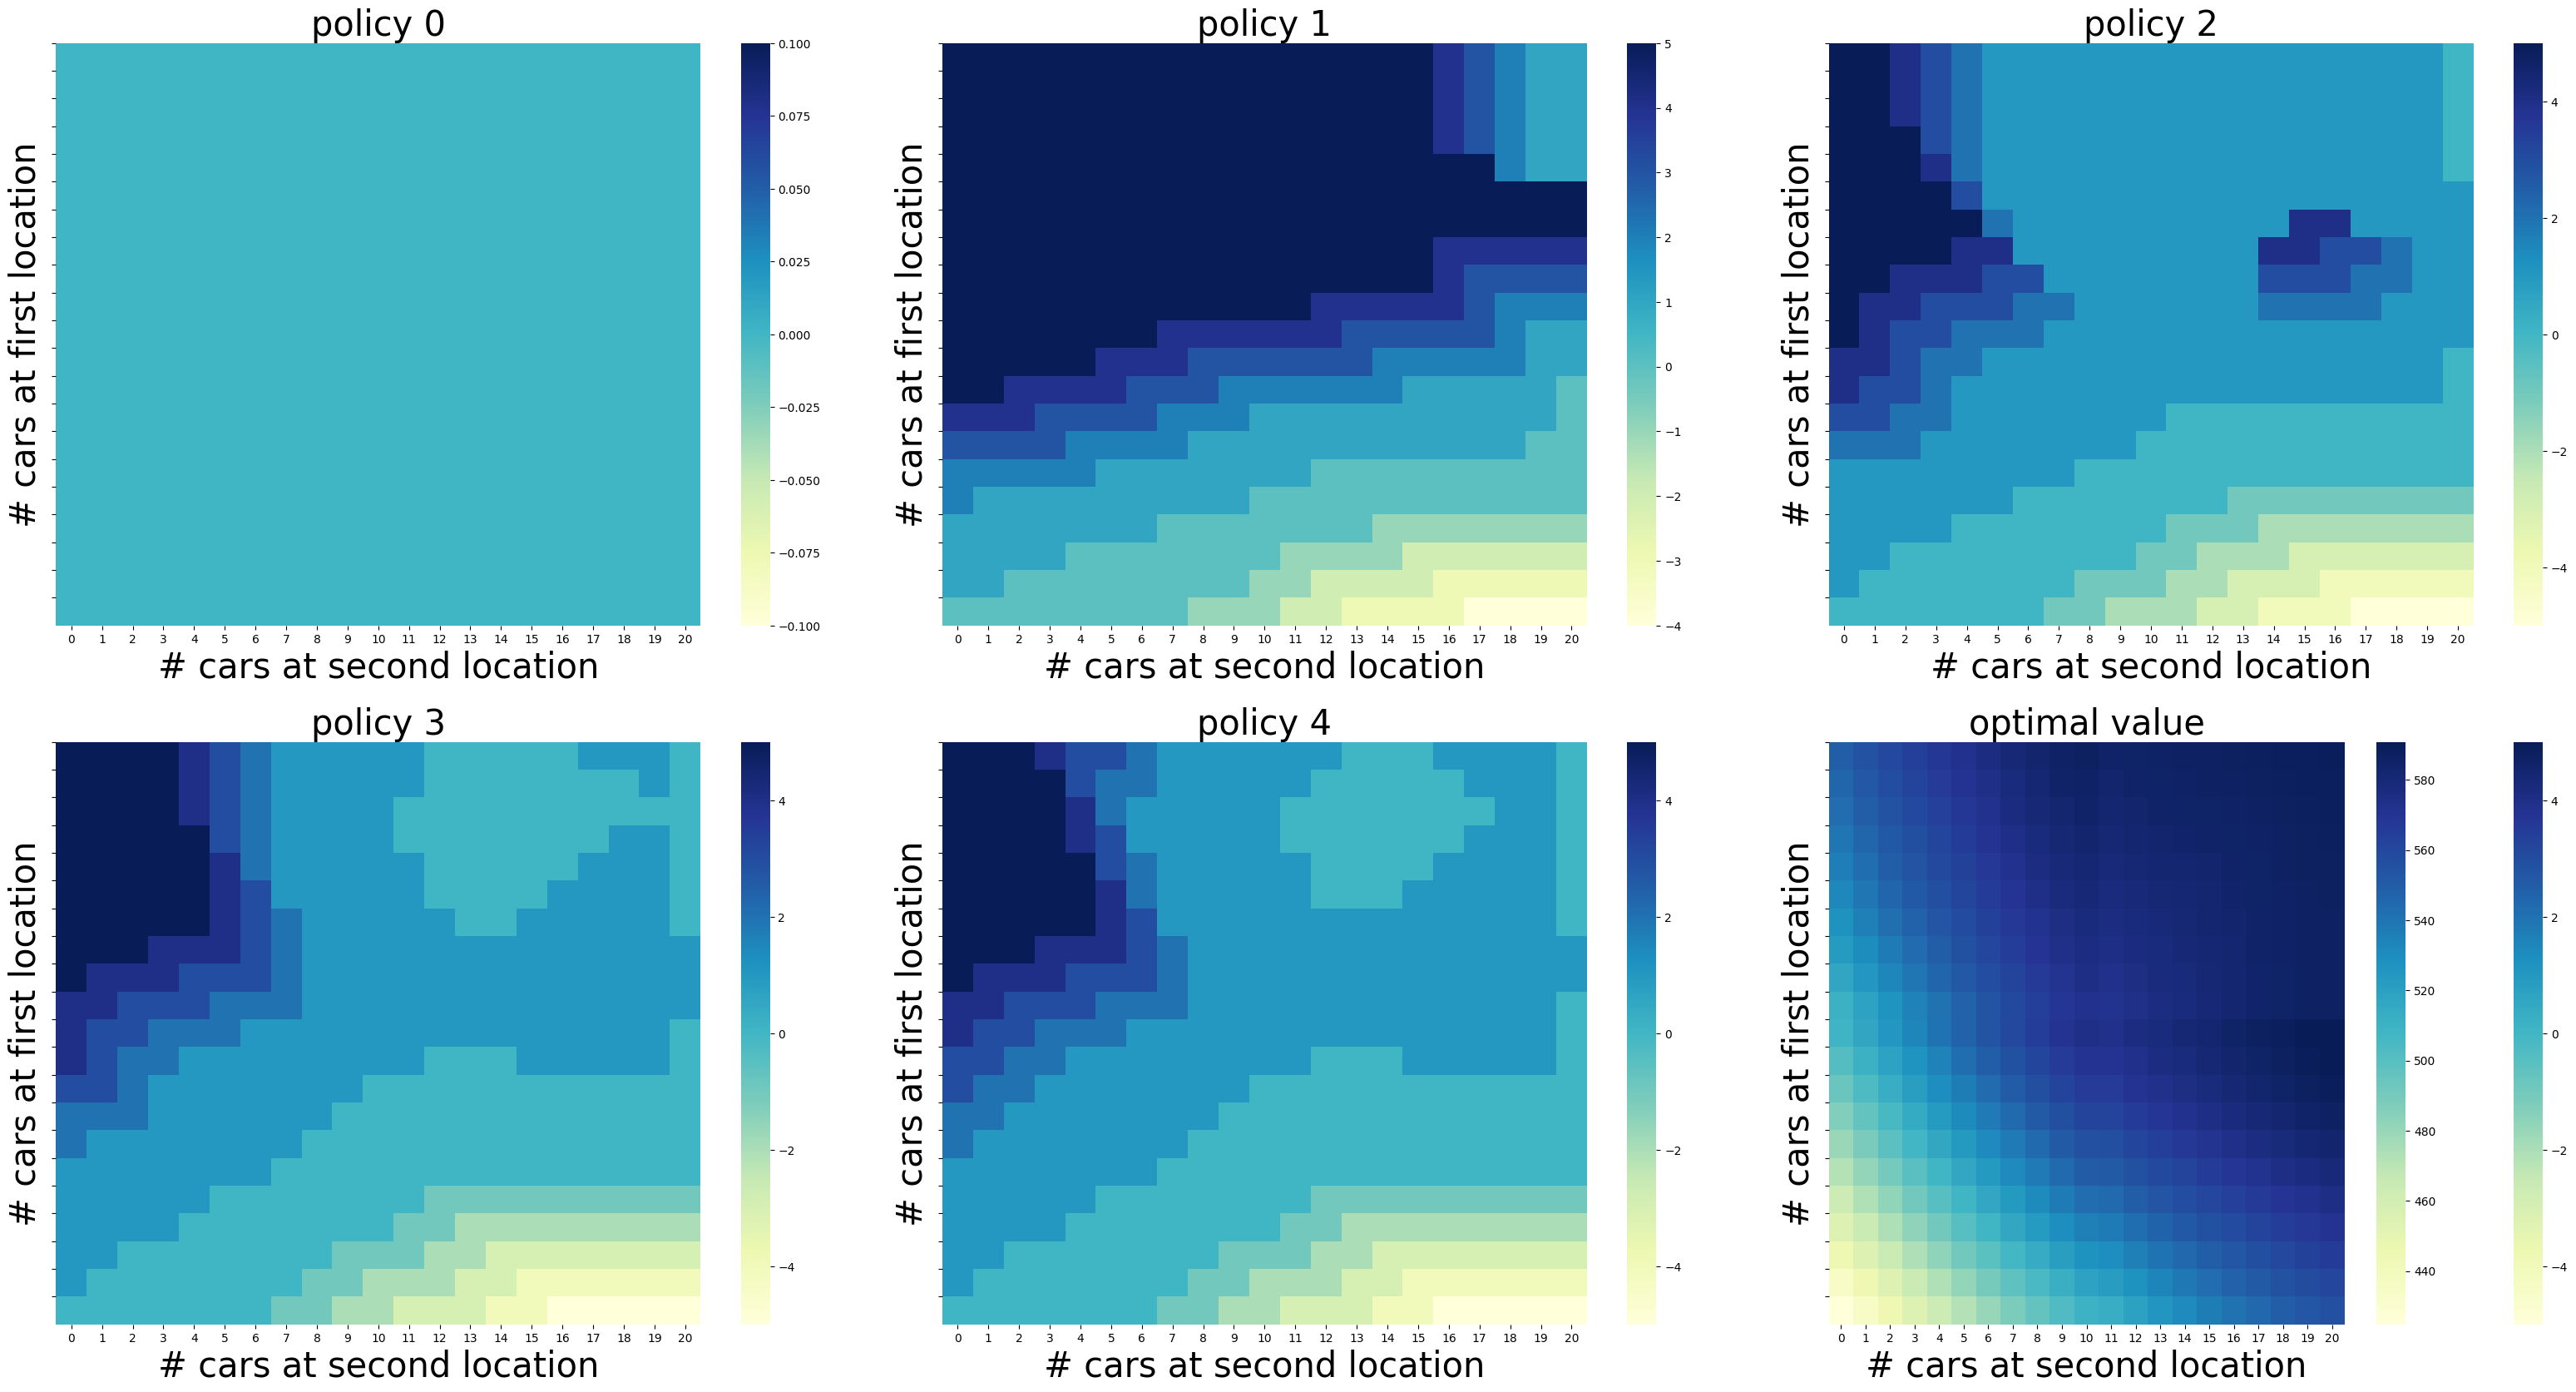

In [23]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# maximum number of vehicles free of charge in a parking lot
MAX_FREE_PARK_SLOT = 10

# cost for unlocking an extra parking lot
EXTRA_PARKING_LOT_COST = 4

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()

def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    # cost for moving cars
    # we can now shuttle one car to the second location for free
    if action > 0:
        returns -= MOVE_CAR_COST * abs(action - 1)
    else:
        returns -= MOVE_CAR_COST * abs(action)
    
    # additional parking lots price in the morning
    if state[0] > MAX_FREE_PARK_SLOT:
        returns -= EXTRA_PARKING_LOT_COST
    if state[1] > MAX_FREE_PARK_SLOT:
        returns -= EXTRA_PARKING_LOT_COST


    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# This is the parameter of the function in the original code
constant_returned_cars = True

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

policy = np.zeros(value.shape, dtype=np.int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

# Code for value iteration algorithm and figures
OPTIONAL_POINT = False

# YOUR CODE HERE

while True:
    
    fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
    fig.set_ylabel('# cars at first location', fontsize=30)
    fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
    fig.set_xlabel('# cars at second location', fontsize=30)
    fig.set_title('policy {}'.format(iterations), fontsize=30)

    # policy evaluation (in-place)
    while True:
        old_value = value.copy()
        # Sweep through all states following the same policy
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                # in-place update!
                value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()
        print('max value change {}'.format(max_value_change))
        # termination condition
        if max_value_change < 1e-4:
            break

    # policy improvement
    policy_stable = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                # if it is a 'legal' action, i.e. I am not trying to move more cars than I have in that location
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                # fraud against the car rental company ---> lawyers, possible imprisonment, very low reward
                else:
                    action_returns.append(-np.inf)
            # Substitution with greedy policy at all states
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            if policy_stable and old_action != new_action:
                policy_stable = False
    print('policy stable {}'.format(policy_stable))
    # If not stable, back to the previous while, and iterate!

    # If stable instead
    if policy_stable:
        fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('optimal value', fontsize=30)
        break

    iterations += 1

plt.show()

In [18]:
# HERE ENDS THE SECOND EXERCISE
assert policy.shape == (21, 21)

Comment your results in the cell below. Can you give an intuitive explanation for the optimal policy you found? [~15 lines]

YOUR ANSWER HERE